# Проект: Обучение с учителем: качество модели

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Шаг 1. Загрузка данных

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_context(context='notebook')
import phik
from phik.report import plot_correlation_matrix
import shap

# Загружаем класс pipeline
from sklearn.pipeline import Pipeline

# Загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler,  LabelEncoder
from sklearn.compose import ColumnTransformer

# Загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# Загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
# Загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Импортируем класс OptunaSearchCV()
from optuna.integration import OptunaSearchCV 
from optuna import distributions

# Загружаем метрики
from sklearn.metrics import accuracy_score

C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Загрузим файлы в переменные
try:
  customers_data = pd.read_csv('market_file.csv')
  revenue_data = pd.read_csv('market_money.csv')
  time_data = pd.read_csv('market_time.csv')
  income_data = pd.read_csv('money.csv', delimiter=';')
except:
  customers_data = pd.read_csv('/datasets/market_file.csv')
  revenue_data = pd.read_csv('/datasets/market_money.csv')
  time_data = pd.read_csv('/datasets/market_time.csv')
  income_data = pd.read_csv('/datasets/money.csv', delimiter=';')

**Выведем первые 10 строчек таблицы `market_file.csv` и общую информацию о ней.**

Таблица содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

**Описание данных**
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [3]:
customers_data.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


In [4]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Выведем первые 10 строчек таблицы `market_money.csv` и общую информацию о ней.**

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

**Описаные данных**
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка` — сумма выручки за период.

In [5]:
revenue_data.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [6]:
revenue_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Выведем первые 10 строчек таблицы `market_time.csv` и общую информацию о ней.**

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

**Описание данных**
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведённого на сайте, в минутах.

In [7]:
time_data.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


In [8]:
time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Выведем первые 10 строчек таблицы `money.csv` и общую информацию о ней.**

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Описание данных**
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

In [9]:
income_data.head(10)

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"
5,215353,"3,95"
6,215354,"3,62"
7,215355,"5,26"
8,215356,"4,93"
9,215357,"4,66"


In [10]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


### Вывод

Мы загрузили в тетрадку четыре csv-файла, вывели первые 10 строчек каждого из них, изучили описание данных и общую информацию. Видно, что в таблицах нет пропущенных значений, но некоторые признаки имеют неправильный тип данных. Названия столбцов оставим кириллическими для лучшего понимания признаков.

## Шаг 2. Предобработка данных

In [11]:
# Посчитаем дубликаты в таблицах
print('Количество дубликатов в market_file.csv:', customers_data.duplicated().sum())
print('Количество дубликатов в market_money.csv:', revenue_data.duplicated().sum())
print('Количество дубликатов в market_time.csv:', time_data.duplicated().sum())
print('Количество дубликатов в money.csv:', income_data.duplicated().sum())

Количество дубликатов в market_file.csv: 0
Количество дубликатов в market_money.csv: 0
Количество дубликатов в market_time.csv: 0
Количество дубликатов в money.csv: 0


**Исправим типы данных в датафрейме**

**Заменим запятую в числах на точку и поменяем тип на float, так как запятая в числах мешает поменять тип данных на float, поэтому мы ее заменим на точку**

In [12]:
income_data["Прибыль"] = income_data['Прибыль'].str.replace(',', '.').astype(float)

In [13]:
# Проверим изменения
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [14]:
# Проверим данные на наличие пропущенных значений
print(customers_data.isna().sum())
print()
print(revenue_data.isna().sum())
print()
print(time_data.isna().sum())
print()
print(income_data.isna().sum())

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id         0
Период     0
Выручка    0
dtype: int64

id        0
Период    0
минут     0
dtype: int64

id         0
Прибыль    0
dtype: int64


In [15]:
# Проверим неявные дубликаты в customers_data
print(customers_data['Покупательская активность'].unique())
print()
print(customers_data['Тип сервиса'].unique())
print()
print(customers_data['Разрешить сообщать'].unique())
print()
print(customers_data['Популярная_категория'].unique())

['Снизилась' 'Прежний уровень']

['премиум' 'стандартт' 'стандарт']

['да' 'нет']

['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [16]:
# Исправим опечатки
customers_data.loc[customers_data['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'
customers_data.loc[customers_data['Популярная_категория'] == 'Косметика и аксесуары', 'Популярная_категория'] = 'Косметика и аксессуары'
# Проверим изменения
print(customers_data['Тип сервиса'].unique())
print(customers_data['Популярная_категория'].unique())

['премиум' 'стандарт']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [17]:
# Проверим неявные дубликаты в других датафреймах
print(revenue_data['Период'].unique())
print()
print(time_data['Период'].unique())

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

['текущий_месяц' 'предыдцщий_месяц']


In [18]:
# Исправим опечатки
time_data.loc[time_data['Период'] == 'предыдцщий_месяц', 'Период'] = 'предыдущий_месяц'
# Проверим изменения
print(time_data['Период'].unique())

['текущий_месяц' 'предыдущий_месяц']


In [19]:
# Выбираем категориальные признаки и приводим все значения в этих столбцах к нижнему регистру
for col in customers_data.select_dtypes(include=['object']).columns:
    customers_data[col] = customers_data[col].str.lower()

for col in revenue_data.select_dtypes(include=['object']).columns:
    revenue_data[col] = revenue_data[col].str.lower()

for col in time_data.select_dtypes(include=['object']).columns:
    time_data[col] = time_data[col].str.lower()

### Вывод

Мы проверили данные на наличие пропусков и дубликатов, исправили типы данных там, где нужно. Пропущенных значений в данных нет. Колонки с числами в датасете `money.csv` имели тип object, мы заменили на float64. Нашли и избавились от неявных дубликатов в таблице `customers_data`. Привели значения категориальных признаков к нижнему регистру. 

## Шаг 3. Исследовательский анализ данных

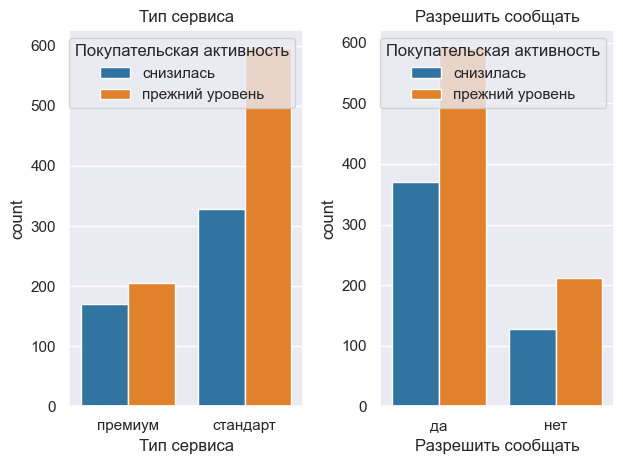

In [20]:
features = ["Тип сервиса", "Разрешить сообщать"]

fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.countplot(data=customers_data, x=feature, hue='Покупательская активность', ax=axes[i])
    axes[i].set_title(feature)


plt.tight_layout()
plt.show()

- Большая часть людей пользуются стандартной версией сервера и их покупательская активность осталась на прежнем уровне
- У покупателей, давших согласие на отправку дополнительных предложений о товарах, покупательская активность осталась прежней

C:\Users\abina\AppData\Local\Temp\ipykernel_20196\3229773255.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha="right")


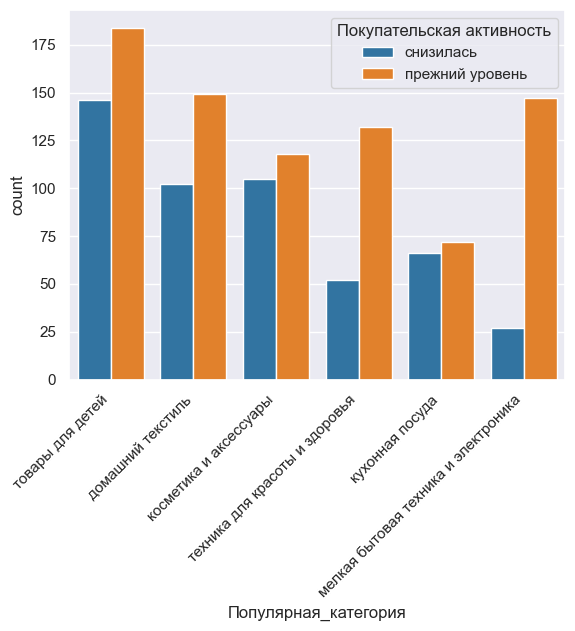

In [21]:
fig = sns.countplot(data=customers_data, x='Популярная_категория', hue='Покупательская активность')
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha="right")
plt.show()

У большинства покупателей, у которых самая популярная категория "товары для детей", "домашний текстиль", "техника для красоты и здоровья", "мелкая бытовая техника и электроника", покупательская активность осталась прежней. У половины покупателей, чья самая популярная категория это "кухонная посуда", уровень покупательской активности снизился, а у другой половины осталась прежней. 

In [22]:
def plot_boxplot_histogram(data, column_name):
    """
    Строит график с двумя подграфиками: ящик с усами и гистограмма.

    Args:
        data: Pandas DataFrame.
        column_name: Название столбца для построения графиков.
    """

    if not isinstance(data, pd.DataFrame):
        raise TypeError("Таблица должна иметь тип Pandas DataFrame.")
    if column_name not in data.columns:
        raise ValueError(f"Столбец '{column_name}' не найден в таблице.")
    if not pd.api.types.is_numeric_dtype(data[column_name]):
        raise ValueError(f"Столбец '{column_name}' должен содержать числовые данные.")


    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

    sns.boxplot(data=data, x=column_name, y='Покупательская активность', ax=ax1)
    ax1.set_title(f"Ящик с усами для {column_name}")


    sns.histplot(data=data, x=column_name, hue='Покупательская активность', ax=ax2, kde=True) # kde=True добавляет кривую плотности
    ax2.set_title(f"Гистограмма для {column_name}")


    plt.show()

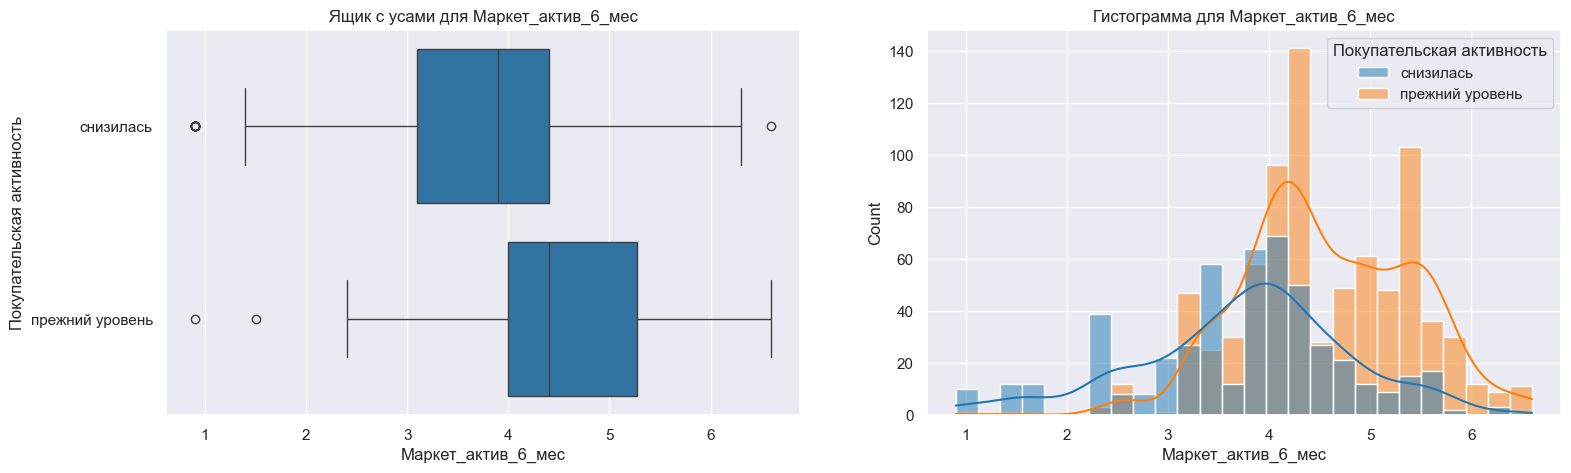

In [23]:
plot_boxplot_histogram(customers_data, "Маркет_актив_6_мес")

Признак `Маркет_актив_6_мес` показывает среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента. Покупатели с прежним уровнем получают больше маркентинговых коммуникаций компании, чем покупатели, у которых уровень снизился. 

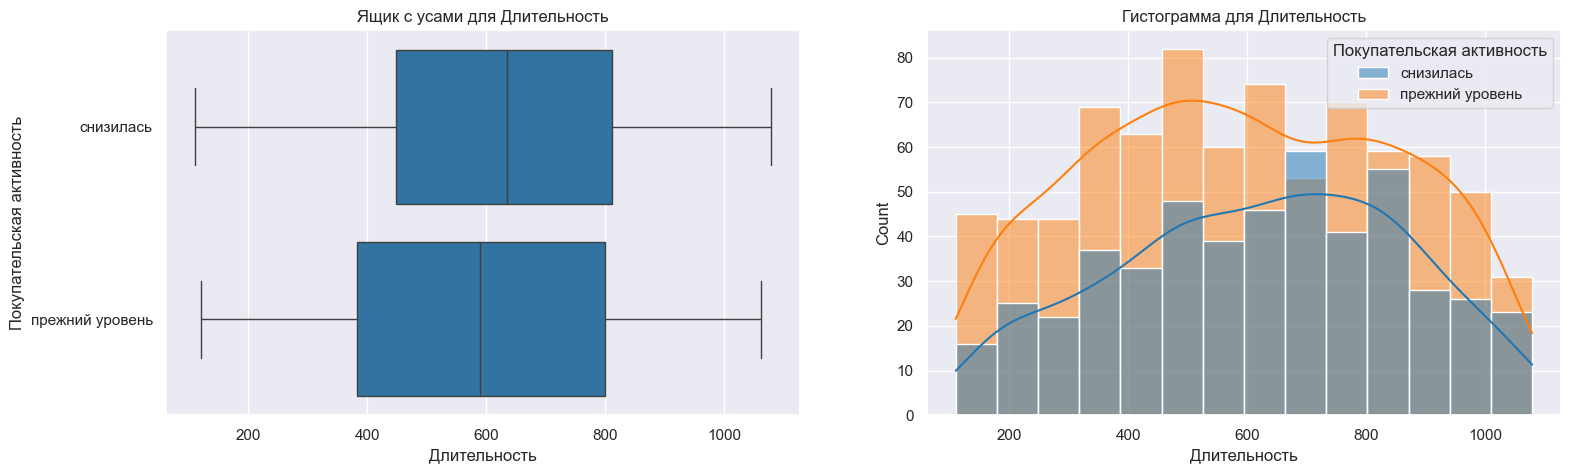

In [24]:
plot_boxplot_histogram(customers_data, "Длительность")

Признак `Длительность` показывает, сколько дней прошло с момента регистрации покупателя на сайте. Покупатели, чей уровень покупательной активности снизился, зарегистрированы на сайте дольше,чем покупатели, у которых покупательская активность осталась прежней. Выбросов у обоих групп не было обнаружено. 

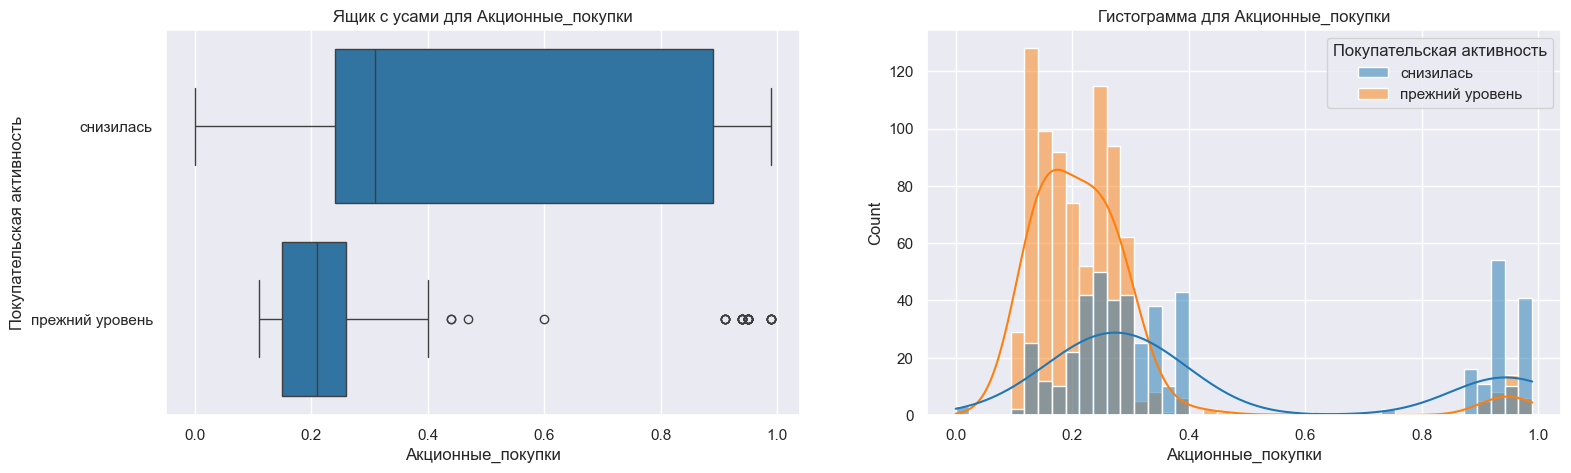

In [25]:
plot_boxplot_histogram(customers_data, "Акционные_покупки")

Признак `Акционные_покупки` показывает среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев. Покупатели, у которых уровень покупательной активности снизился, имеют больше акционных покупок, чем покупатели с прежним уровнем. 

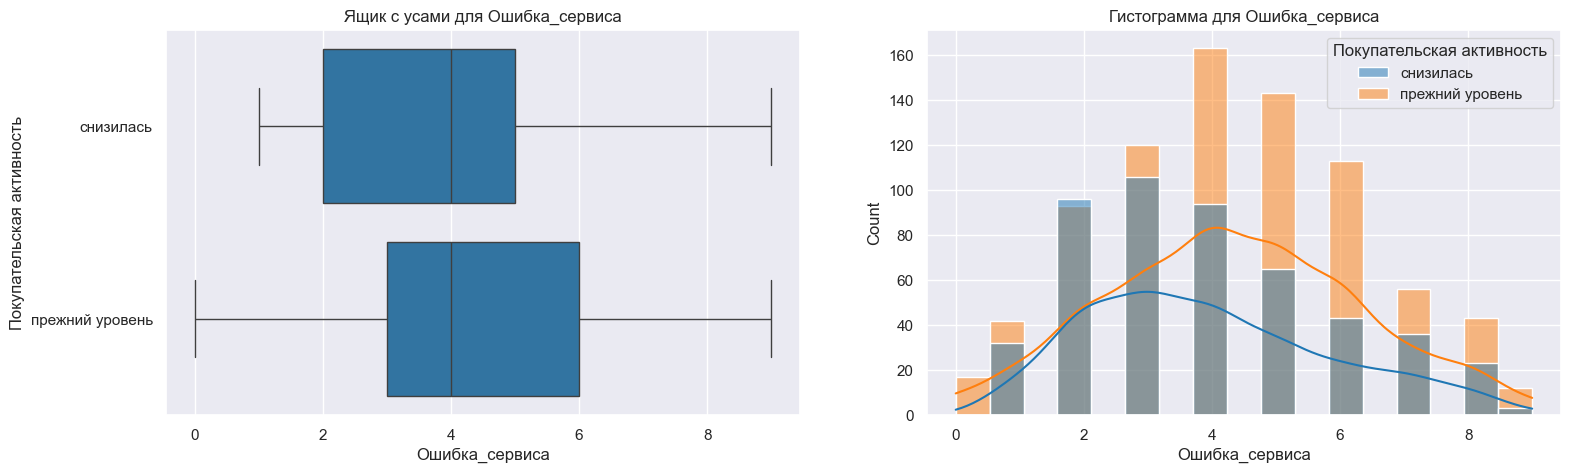

In [26]:
plot_boxplot_histogram(customers_data, "Ошибка_сервиса")

Признак `Ошибка_сервиса` показывает число сбоев, которые коснулись покупателя во время посещения сайта. Покупатели с прежним уровнем и со сниженным имеют одинаковое число сбоев. 

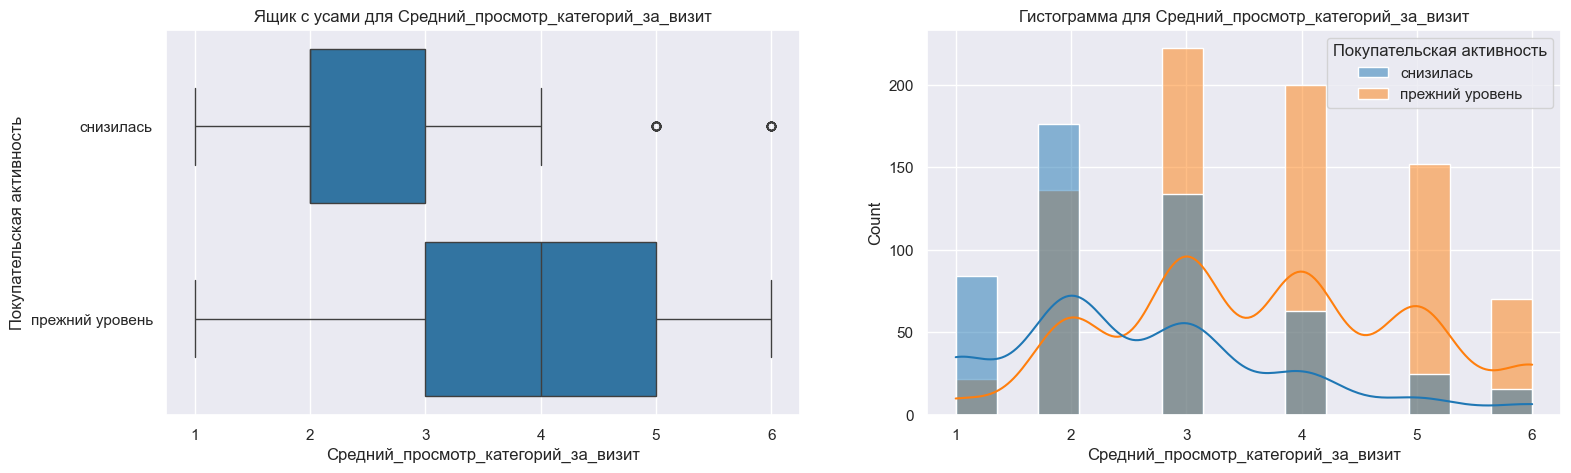

In [27]:
plot_boxplot_histogram(customers_data, "Средний_просмотр_категорий_за_визит")

Признак `Средний_просмотр_категорий_за_визит` показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца. Покупатели с прежним уровнем покупательской активности просматривает больше категорий в среднем, чем покупатели со сниженным уровнем. 

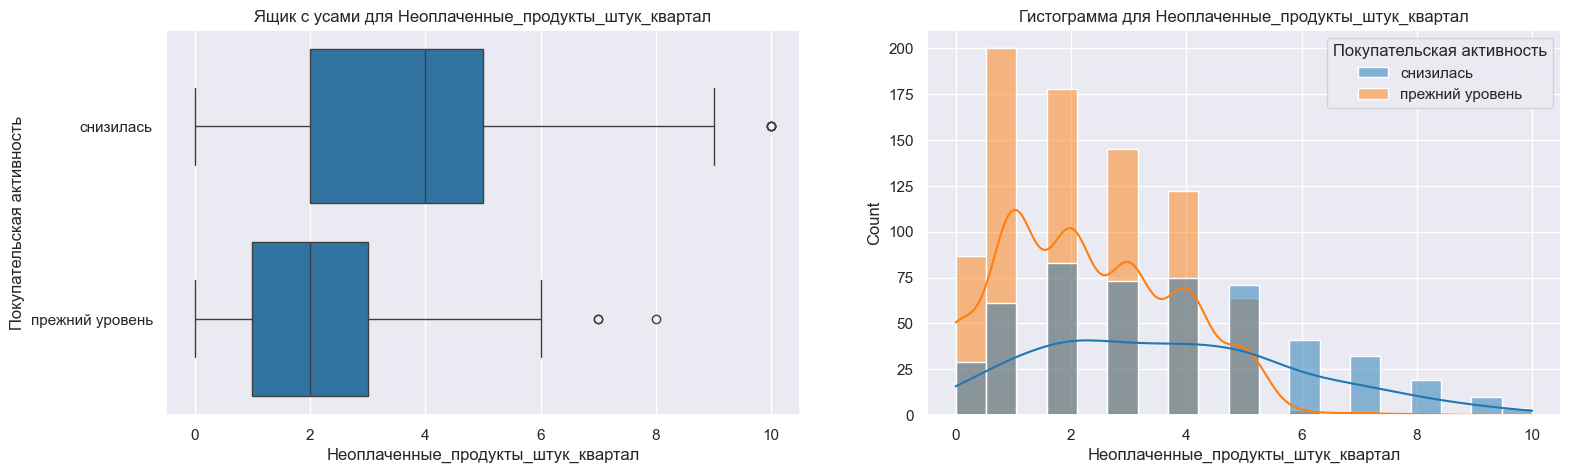

In [28]:
plot_boxplot_histogram(customers_data, "Неоплаченные_продукты_штук_квартал")

Признак `Неоплаченные_продукты_штук_квартал` показывает общее число неоплаченных товаров в корзине за последние 3 месяца. Покупатели со сниженным уровнем имеют большое количество неоплаченных товаров в корзине, чем покупатели с прежним уровнем. Это может значить, что покупатели со сниженным уровнем не оплачивают товары в своей корзине, а покупатели с прежним уровнем продолжают оплачивать продукты. 

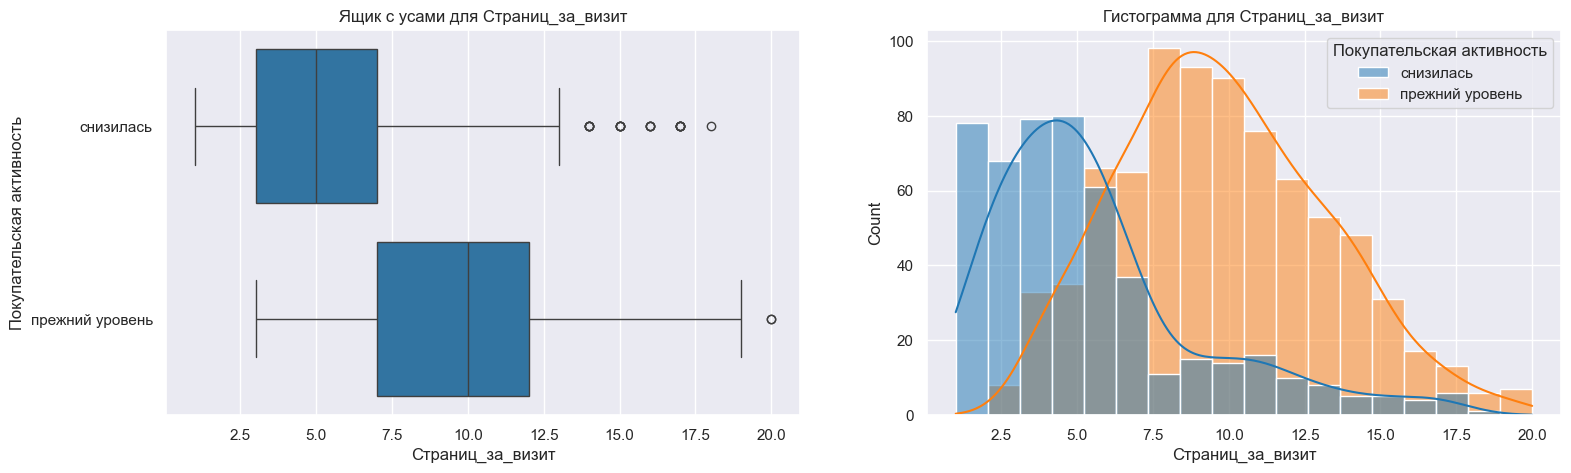

In [29]:
plot_boxplot_histogram(customers_data, "Страниц_за_визит")

Признак `Страниц_за_визит` показывает среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. Покупатели со сниженным уровнем просматривают меньше страниц на сайте, чем покупатели с прежним уровнем. Значит, что покупатели с прежним уровнем активнее просматривают сайт, чем покупатели со сниженным, что логично. 

,Период,Выручка
0,предыдущий_месяц,4936.920385
1,препредыдущий_месяц,4825.206923
2,текущий_месяц,5314.960846


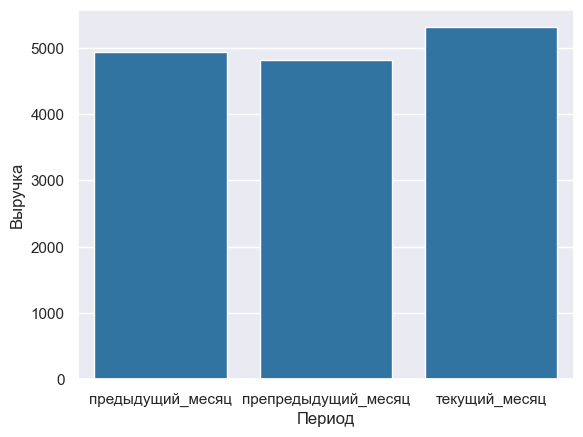

In [30]:
revenue_agg = revenue_data.groupby('Период')['Выручка'].mean().reset_index()
sns.barplot(data=revenue_agg, x='Период', y='Выручка')
display(revenue_agg)
plt.show()

В таблице `market_money.csv` лежат данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Покупатели в текущем месяце потратили больше денег, чем в прошлые месяцы. 

,Период,минут
0,предыдущий_месяц,13.467692
1,текущий_месяц,13.204615


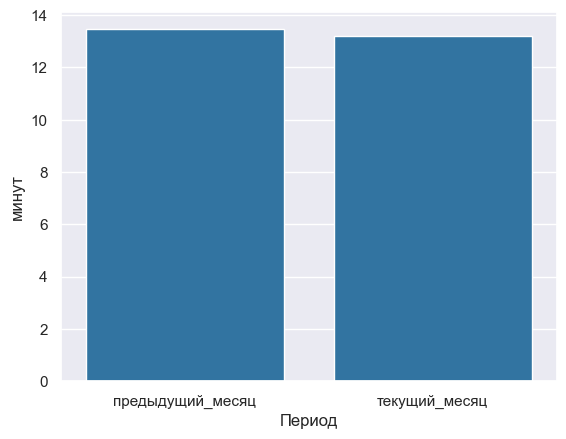

In [31]:
time_agg = time_data.groupby('Период')['минут'].mean().reset_index()
sns.barplot(data=time_agg, x='Период', y='минут')
display(time_agg)
plt.show()

,Покупательская активность,count
0,прежний уровень,802
1,снизилась,498


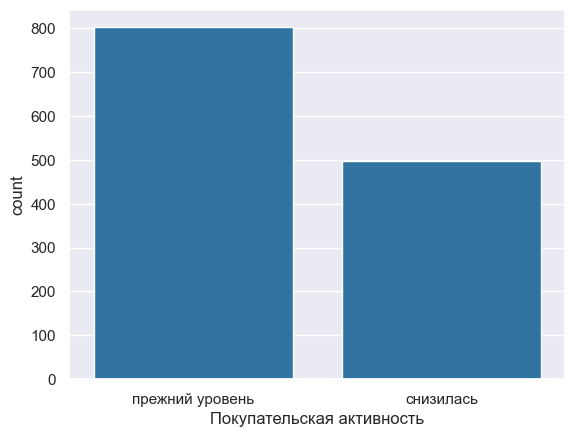

In [106]:
notif_agg = customers_data['Покупательская активность'].value_counts().reset_index()
sns.barplot(data=notif_agg, x='Покупательская активность', y='count')
display(notif_agg)
plt.show()

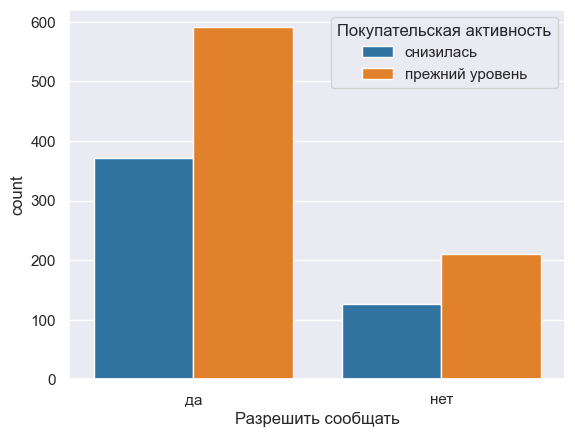

In [108]:
sns.countplot(data=customers_data, x='Разрешить сообщать', hue='Покупательская активность')
plt.show()

### Вывод

- Клиенты со сниженным уровнем покупательской активности получает меньше маркетинговых коммуникаций, чем клиенты с прежним уровнем
- Клиенты со сниженным уровнем покупают делают больше акционных покупок, товары по акции встречаются реже, чем регулярные
- Клиенты со сниженным уровнем покупательской активности имеют больше неоплаченных товаров в корзине, зарегистрированы на сайте дольше, просматривают больше категорий и страниц, чем покупатели с прежним уровнем
- У клиентов, не давших согласие на предложениях о товаре, уровень покупательской активности снизился

В таблице `market_file.csv` лежат данные о времени (в минутах), которое покупатель провёл на сайте в течение периода. На графике видно, что покупатели проводят такое же время на сайте в текущем месяце ,что и предыдущем месяце. 

In [33]:
customers_data['Покупательская активность'].value_counts(normalize=True).reset_index()

,Покупательская активность,proportion
0,прежний уровень,0.616923
1,снизилась,0.383077


В датасете классы целевого признака имеют соотношение 6:4. Класса `прежний уровень` почти в два раза больше, чем класса `снизилась`. В данных дисбаланс классов, поэтому при разделении датафрейма на тренировочную и тестовую выборки нужно произвести стратификацию. 

**Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оставим только тех покупателей, у которых выручка в трех месяцах не равна нулю.**

In [34]:
market_money_pivot = revenue_data.pivot(index='id',
                                        columns='Период',
                                        values='Выручка')

market_money_pivot.query('предыдущий_месяц !=0 & препредыдущий_месяц != 0 & текущий_месяц !=0')

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


**Оставим только активных покупателей в данных**

In [35]:
active_buyers = market_money_pivot.query('предыдущий_месяц !=0 & препредыдущий_месяц != 0 & текущий_месяц !=0').reset_index()['id'].to_list()

market_file = customers_data[customers_data['id'].isin(active_buyers)]
market_money = revenue_data[revenue_data['id'].isin(active_buyers)]
market_time = time_data[time_data['id'].isin(active_buyers)]
money_data = income_data[income_data['id'].isin(active_buyers)]

## Шаг 4. Объединение таблиц

**Создадим сводные таблицы по периоду и переминуем названия столбцов, чтобы объединить данные в одну таблицу**

In [36]:
new_market_money = market_money.pivot_table(index='id', columns='Период', values='Выручка')
new_market_money = new_market_money.rename(
    columns={
        'предыдущий_месяц': 'Выручка_за_прошлый_месяц',
        'препредыдущий_месяц': 'Выручка_за_предпрошлый_месяц',
        'текущий_месяц':'Выручка_за_текущий_месяц'
    }
)
new_market_money

Период,Выручка_за_прошлый_месяц,Выручка_за_предпрошлый_месяц,Выручка_за_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [37]:
new_market_time = market_time.pivot_table(index='id', columns='Период', values='минут').reset_index()
new_market_time = new_market_time.rename(
    columns = {
        'предыдущий_месяц': 'Минут_в_прошлый_месяц',
        'текущий_месяц': 'Минут_в_текущий_месяц'
    }
)
new_market_time

Период,id,Минут_в_прошлый_месяц,Минут_в_текущий_месяц
0,215349,12.0,10.0
1,215350,8.0,13.0
2,215351,11.0,13.0
3,215352,8.0,11.0
4,215353,10.0,10.0
...,...,...,...
1292,216643,14.0,7.0
1293,216644,12.0,11.0
1294,216645,12.0,18.0
1295,216646,18.0,7.0


In [38]:
# Объединим все три файла в одну таблицу
data = market_file.merge(new_market_money, on='id')
data = data.merge(new_market_time, on='id')
data 

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_за_прошлый_месяц,Выручка_за_предпрошлый_месяц,Выручка_за_текущий_месяц,Минут_в_прошлый_месяц,Минут_в_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,прежний уровень,стандарт,да,6.6,3,318,0.24,техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14.0,7.0
1293,216644,прежний уровень,стандарт,нет,5.1,4,454,0.21,домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12.0,11.0
1294,216645,прежний уровень,стандарт,да,4.1,3,586,0.20,домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12.0,18.0
1295,216646,прежний уровень,стандарт,да,6.3,5,645,0.12,техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18.0,7.0


In [39]:
# Проверим новый общий датасет на наличие пропущенных значений
data.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
Выручка_за_прошлый_месяц               0
Выручка_за_предпрошлый_месяц           0
Выручка_за_текущий_месяц               0
Минут_в_прошлый_месяц                  0
Минут_в_текущий_месяц                  0
dtype: int64

### Вывод

Аггрегировали файлы `market_money.csv` и `market_money.csv`, чтобы объединить данные с `market_file.csv` в один большой файл для обучения модели. 

## Шаг 5. Корреляционный анализ

In [40]:
# Найдем коэффициенты корреляции 
interval_cols = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки',
                  'Выручка_за_прошлый_месяц', 'Выручка_за_предпрошлый_месяц', 'Выручка_за_текущий_месяц',
                  'Минут_в_прошлый_месяц', 'Минут_в_текущий_месяц']
phik_overview = data.phik_matrix(interval_cols=interval_cols)

C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable id is large: 1297. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(


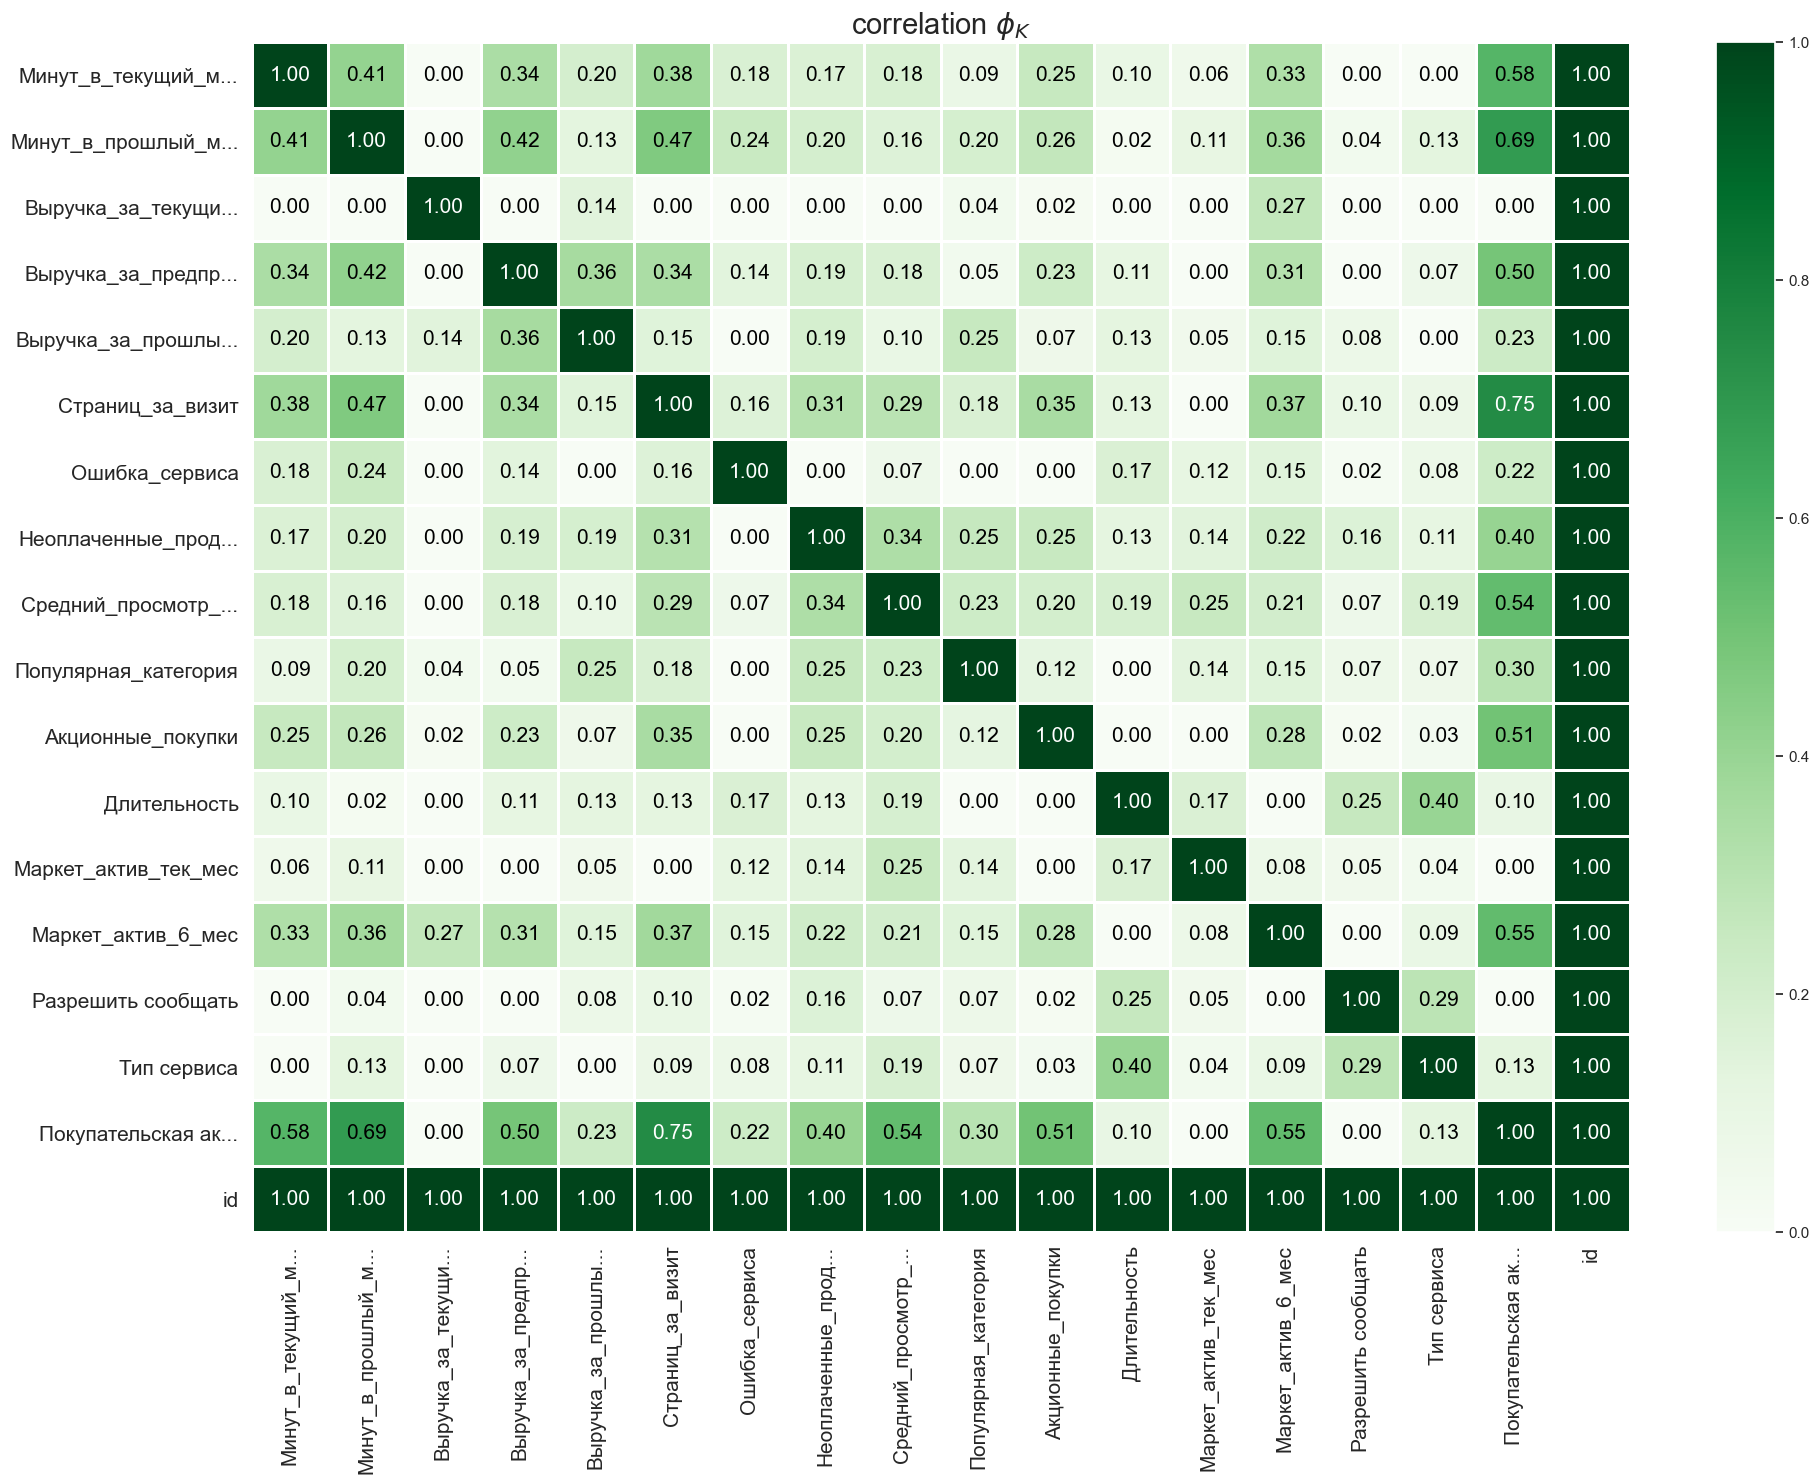

In [41]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

### Вывод

Наблюдаются следующие заметные корреляции с целевым признаком `Покупательская_активность`:
- между `Выручка_за_текущий_месяц` 0,58
- между `Выручка_за_прошлый_месяц` 0,69
- между `Выручка_за_предпрошлый_месяц` 0,50
- между `Страниц_за_визит` 0,75
- между `Средний_просмотр_категорий_за_визит` 0,54
- между `Акционные_покупки` 0,51
- между `Маркет_актив_6_мес` 0,55

Нет корреляций с коэффициентами 0.9 до 0.95, значит, мультиколлинеарности не наблюдается между входными признаками. Также не наблюдается утечка целевого признака, нет корреляции между целевым и входными признаками с коэффициентом равным единице. 

## Шаг 6. Использование пайплайнов

- Подготовим данные для обучения модели: кодируем категориальные признаки и масштабируем количественные, используя несколько способов;
- Обучим четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC();
- Подберем гиперпараметры с помощью автоматизированного подбора гиперпараметров;
- Используем метрику ROC-AUC для подбора параметров и оценивания моделей, так как она не зависит от порога классификации.

In [44]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Выделяем целевой и входные признаки
X = data.drop(['Покупательская активность'], axis=1)
y = data['Покупательская активность']
# Разделим датасет на тренировочную и тестовую выборки
X_train, X_test, y_train_no_encoder, y_test_no_encoder = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

print(X_train.shape, X_test.shape)

(972, 17) (325, 17)


In [45]:
# Cоздадим экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()
label_encoder.fit(['прежний уровень', 'снизилась'])

y_train = label_encoder.transform(y_train_no_encoder)
y_test = label_encoder.transform(y_test_no_encoder) 

In [46]:
pd.DataFrame(y_train, y_train_no_encoder, columns=['LabelEncoder'])

,LabelEncoder
Покупательская активность,
прежний уровень,0
снизилась,1
прежний уровень,0
прежний уровень,0
снизилась,1
...,...
прежний уровень,0
прежний уровень,0
снизилась,1


Класс `прежний уровень` закодирован как 0, а класс `снизилась` - 1. 

In [47]:
# Создадим списки с количественными и категориальными признаками
cat_col_names = X_train.select_dtypes(exclude='number').columns.tolist()
num_col_names = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
                'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
                'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 
                'Выручка_за_прошлый_месяц', 'Выручка_за_предпрошлый_месяц', 'Выручка_за_текущий_месяц', 
                'Минут_в_прошлый_месяц', 'Минут_в_текущий_месяц']

print('Категориальные признаки:', cat_col_names)
print('Количественные признаки:', num_col_names)

Категориальные признаки: ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
Количественные признаки: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_за_прошлый_месяц', 'Выручка_за_предпрошлый_месяц', 'Выручка_за_текущий_месяц', 'Минут_в_прошлый_месяц', 'Минут_в_текущий_месяц']


In [48]:
# Cоздадим пайплайн для подготовки признаков из списка cat_col_names: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

# Cоздадим общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_col_names),
    ('num', StandardScaler(), num_col_names)
], remainder='passthrough')

# Cоздадим пайплайны для четырех моделей: подготовка данных и модель
decision_tree_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

lr_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1'))
])

knn_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', KNeighborsClassifier())
])

svc_pipeline = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', SVC(random_state=RANDOM_STATE, probability=True))
])

In [49]:
decision_tree_parameters = {'models__min_samples_split': distributions.IntDistribution(2, 11),
              'models__min_samples_leaf': distributions.IntDistribution(1, 11),
              'models__max_depth': distributions.IntDistribution(2,11),
              'preprocessor__num': distributions.CategoricalDistribution(['passthrough',
                                                  StandardScaler(),
                                                  MinMaxScaler(),
                                                  RobustScaler()])
             }

decision_tree_oscv = OptunaSearchCV(estimator=decision_tree_pipeline,
                      param_distributions=decision_tree_parameters,
                      scoring='roc_auc',
                      cv=5,
                      n_trials=20,
                      random_state=RANDOM_STATE
                     )
# Обучим модель
decision_tree_oscv.fit(X_train[cat_col_names + num_col_names], y_train) 
print('Лучшая модель DecisionTreeClassifier и её параметры:\n\n', decision_tree_oscv.best_estimator_)
print ('Метрика лучшей модели DecisionTreeClassifier на тренировочной выборке:', decision_tree_oscv.best_score_)

# Проверим модель на тестовых данных
y_test_pred = decision_tree_oscv.predict(X_test[cat_col_names + num_col_names])
print(f'Метрика ROC-AUC лучшей модели DecisionTreeClassifier на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple 

Лучшая модель DecisionTreeClassifier и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
 

In [50]:
svc_parameters = {
              'models__kernel': distributions.CategoricalDistribution(['rbf', 'sigmoid', 'linear']),
              'models__C': distributions.CategoricalDistribution([0.1,1,10,100]),
              'models__gamma': distributions.CategoricalDistribution([0.1,1,10,100]),
              'preprocessor__num': distributions.CategoricalDistribution(['passthrough',
                                                  StandardScaler(),
                                                  MinMaxScaler(),
                                                  RobustScaler()])
                
             }

svc_oscv = OptunaSearchCV(estimator=svc_pipeline,
                      param_distributions=svc_parameters,
                      scoring='roc_auc',
                      cv=5,
                      n_trials=20,
                      random_state=RANDOM_STATE
                     )
# Обучим модель
svc_oscv.fit(X_train[cat_col_names + num_col_names], y_train) 
print('Лучшая модель SVM и её параметры:\n\n', svc_oscv.best_estimator_)
print ('Метрика лучшей модели SVM на тренировочной выборке:', svc_oscv.best_score_)

# Проверим модель на тестовых данных
y_test_pred = svc_oscv.predict(X_test[cat_col_names + num_col_names])
print(f'Метрика ROC-AUC лучшей модели SVM на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple 

Лучшая модель SVM и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
                    

In [51]:
knn_parameters = {
    'models__n_neighbors': distributions.IntDistribution(2, 11),
    'models__metric': distributions.CategoricalDistribution(['manhattan', 'euclidean']),
    'preprocessor__num': distributions.CategoricalDistribution(['passthrough',
                                                  StandardScaler(),
                                                  MinMaxScaler(),
                                                  RobustScaler()])
}

knn_oscv = OptunaSearchCV(estimator=knn_pipeline,
                      param_distributions=knn_parameters,
                      scoring='roc_auc',
                      cv=5,
                      n_trials=20,
                      random_state=RANDOM_STATE
                     )
# Обучим модель
knn_oscv.fit(X_train[cat_col_names + num_col_names], y_train) 
print('Лучшая модель KNeighborsClassifier и её параметры:\n\n', knn_oscv.best_estimator_)
print ('Метрика лучшей модели KNeighborsClassifier на тренировочной выборке:', knn_oscv.best_score_)

# Проверим модель на тестовых данных
y_test_pred = knn_oscv.predict(X_test[cat_col_names + num_col_names])
print(f'Метрика ROC-AUC лучшей модели KNeighborsClassifier на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple 

Лучшая модель KNeighborsClassifier и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
   

In [52]:
lr_parameters = {
    'models__C': distributions.IntDistribution(1, 5),
    'preprocessor__num': distributions.CategoricalDistribution(['passthrough',
                                                  StandardScaler(),
                                                  MinMaxScaler(),
                                                  RobustScaler()])
}
lr_oscv = OptunaSearchCV(estimator=lr_pipeline,
                      param_distributions=lr_parameters,
                      scoring='roc_auc',
                      cv=5,
                      n_trials=20,
                      random_state=RANDOM_STATE
                     )
# Обучим модель
lr_oscv.fit(X_train[cat_col_names + num_col_names], y_train) 
print('Лучшая модель LogisticRegression и её параметры:\n\n', lr_oscv.best_estimator_)
print ('Метрика лучшей модели LogisticRegression на тренировочной выборке:', lr_oscv.best_score_)

# Проверим модель на тестовых данных
y_test_pred = lr_oscv.predict(X_test[cat_col_names + num_col_names])
print(f'Метрика ROC-AUC лучшей модели LogisticRegression на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
C:\Users\abina\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple 

Лучшая модель LogisticRegression и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Тип сервиса',
                                                   'Разрешить сообщать',
                                                   'Популярная_категория']),
     

### Вывод
Мы построили пайплайны для четырех моделей и с помощью OptunaSearchCV нашли лучшие параметры для моделей:
- Метрика ROC-AUC лучшей модели `LogisticRegression` на тестовой выборке: 0.8839271385010432
- Метрика ROC-AUC лучшей модели `KNeighborsClassifier` на тестовой выборке: 0.8848700048146365
- Метрика ROC-AUC лучшей модели `SVM` на тестовой выборке: 0.8988525116353716
- Метрика ROC-AUC лучшей модели `DecisionTreeClassifier` на тестовой выборке: 0.820273631840796

Лучшие показатели у пайплайна с моделью `SVM`. 

## Шаг 7. Анализ важности признаков

In [53]:
best_svc_model = svc_oscv.best_estimator_
X_train_prepr = best_svc_model.named_steps['preprocessor'].transform(X_train[cat_col_names + num_col_names])
X_test_prepr = best_svc_model.named_steps['preprocessor'].transform(X_test[cat_col_names + num_col_names])
feature_names = list(best_svc_model.named_steps['preprocessor'].get_feature_names_out())

# Возьмем 100 примеров из выборок 
X_train_sample = shap.sample(X_train_prepr, 100)
X_test_sample = shap.sample(X_test_prepr, 100)
explainer = shap.KernelExplainer(best_svc_model.named_steps['models'].predict, X_train_sample)
shap_values = explainer(X_test_sample)

100%|██████████| 100/100 [11:34<00:00,  6.95s/it]


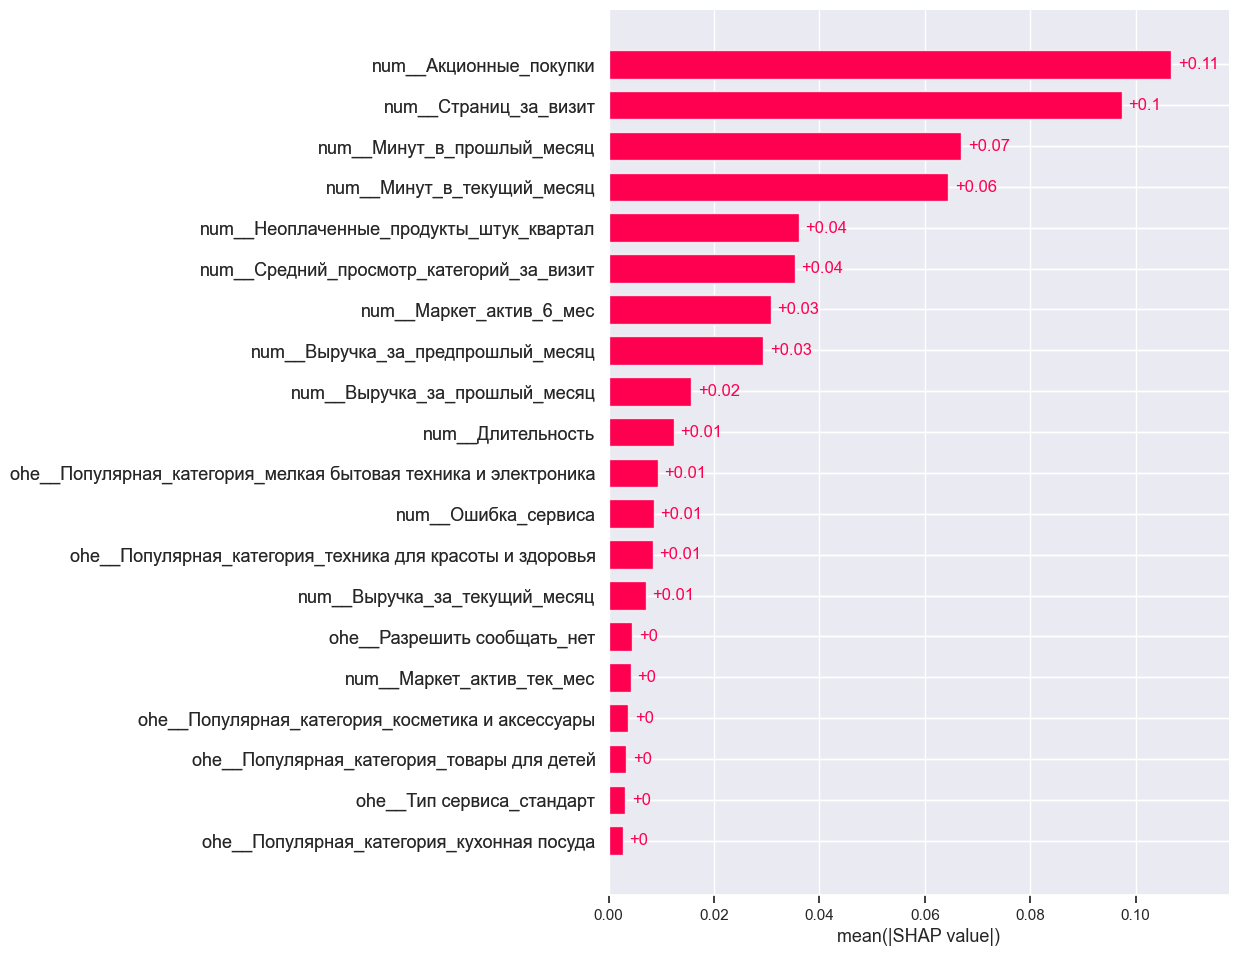

In [54]:
# Преобразование SHAP значений в объект Explanation
base_values = np.repeat(explainer.expected_value, X_test_sample.shape[0])
shap_values_exp = shap.Explanation(values=shap_values, base_values=base_values,
                                   data=X_test_sample, feature_names=feature_names)

# Построим график общей значимости признаков
shap.plots.bar(shap_values_exp, max_display=21)

Признаки на графике расположены в порядке убывания их вклада: начиная с самого важного признака и заканчивая самым малозначимым для модели признаком. Лидирует признак `Акционные_покупки`, а вторым по значимости стал признак `Страниц_за_визит`. Одинаковую значимость имеют признаки `Минут_в_прошлый_месяц` и `Минут_в_текущий_месяц`. Они оба показывают, сколько минут покупатель провел на сайте. 

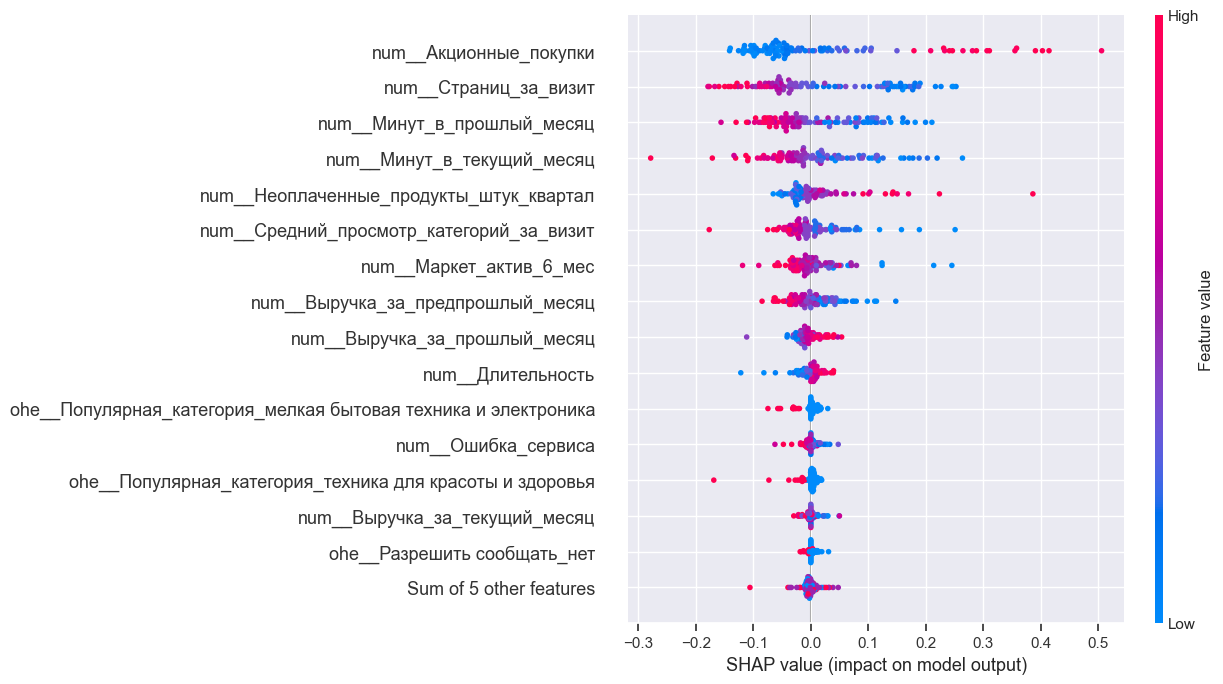

In [55]:
shap.plots.beeswarm(shap_values_exp, max_display=16) 

Высокие значения признака — это красные точки, а значения Шепли ниже нуля определяют принадлежность к классу 0. Низкие значения признака `Акционные_покупки` повышают вероятность отнесения объекта к классу 0. Низкие значения признаков `Страниц_за_визит`, `Мину_в_прошлый_месяц`, `Минут_в_текущий_месяц` повышают вероятность предсказания уровня покупателя к классу `снизилась`, то есть чем меньше покупатель проводит времени на сайте и чем меньше страниц он посещает, тем меньше его покупательская активность. В то время как высокие значение этих же признаков повышают вероятность отнесения уровня покупателя к классу `прежний уровень`. То же самое с признаками `Средний_просмотр_категорий_за_визит` и `Маркет_актив_6_мес`: их высокие значения влияют на предсказание покупателю класс "прежний уровень". Чем больше покупатель просматривает категорий в среднем и чем больше маркетинговых коммуникаций он получает от компании, тем выше его покупательская активность, а точнее уровень его покупательской активности не снижает. 

### Вывод

- Значимые признаки: Акционные покупки, Страниц за визит, Минут в прошлый месяц, Минут в текущий месяц
- Среднезначимые признаки: Неоплаченные продукты штук квартал, Средний просмотр категорий за визит
- Малозначимые признаки: 'Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Ошибка_сервиса', 'Длительность', 'Выручка_за_предпрошлый_месяц', 'Выручка_за_текущий_месяц'

## Шаг 8. Сегментация покупателей

In [56]:
y_train_proba = best_svc_model.predict_proba(X_train)[:, 1]
y_test_proba = best_svc_model.predict_proba(X_test)[:, 1]

X_train['Вероятность_снижения_актив'] = y_train_proba
X_test['Вероятность_снижения_актив'] = y_test_proba

new_data = pd.concat([X_train, X_test], axis=0)
new_data = new_data.merge(data[['id', 'Покупательская активность']], on='id')
new_data = new_data.merge(money_data, on='id')

**Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.**

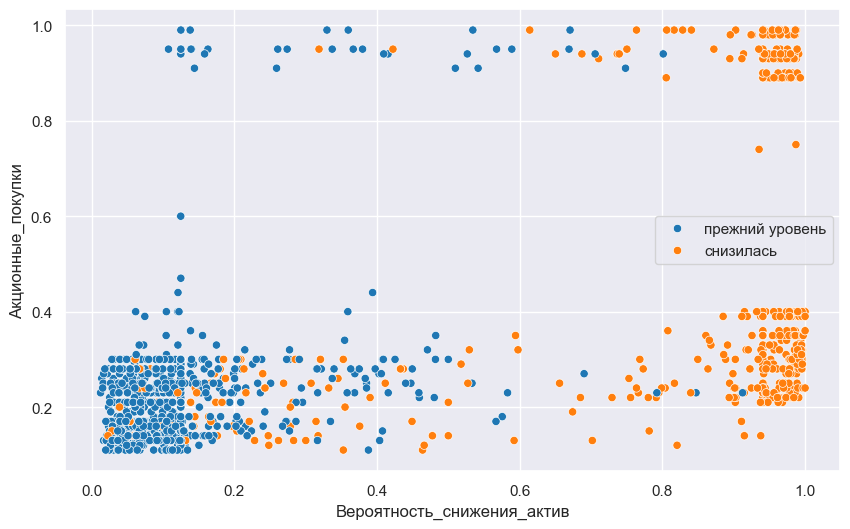

In [57]:
fig,ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=new_data,
            x='Вероятность_снижения_актив',
            y='Акционные_покупки',
            hue='Покупательская активность', 
            ax=ax)

ax.legend(loc="best")
plt.show()

Признак `Акционные_покупки` показывает среднемесячную долю покупок по акции от общего числа покупок за последние 6 месяцев. На диаграмме рассеяния видим, что объекты (покупатели) поделились на два кластера: первая группа, где значение акционных покупок низкое, как и вероятность снижения покупательской активности, а у второй группы при низком значении акционных покупок вероятность снижения покупательской активности высокое. Вторая группа цветом на графике обозначена как покупатели со сниженным уровнем. 

Однако на правом верхнем углу есть группа оранжевых точек, обозначающих покупателей, у которых высокая доля акционных покупок, но при этом уровень покупательской активности снизился. Выделем эту группу покупателей в отдельный сегмент. 

In [58]:
segment_1 = new_data.query('(Вероятность_снижения_актив > 0.8) & (Акционные_покупки > 0.6)')
segment_1

,id,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_за_прошлый_месяц,Выручка_за_предпрошлый_месяц,Выручка_за_текущий_месяц,Минут_в_прошлый_месяц,Минут_в_текущий_месяц,Вероятность_снижения_актив,Покупательская активность,Прибыль
12,215655,стандарт,да,3.9,4,819,0.94,товары для детей,1,9,4,2,4414.0,4847.0,4909.3,13.0,10.0,0.983133,снизилась,4.01
17,215447,стандарт,да,2.4,5,511,0.94,товары для детей,3,2,3,3,3311.0,4677.0,3567.1,6.0,9.0,0.956254,снизилась,4.01
21,215382,стандарт,да,4.6,4,330,0.89,техника для красоты и здоровья,6,2,7,6,5545.5,4824.0,6403.5,15.0,8.0,0.805424,снизилась,2.42
34,215617,стандарт,да,0.9,4,728,0.90,домашний текстиль,2,3,2,4,4798.5,4377.0,5184.6,10.0,14.0,0.973439,снизилась,3.06
40,215573,стандарт,да,4.1,4,706,0.99,кухонная посуда,2,6,2,6,5418.0,4671.0,5501.2,12.0,12.0,0.965674,снизилась,4.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,215365,стандарт,да,3.9,4,167,0.95,техника для красоты и здоровья,6,4,2,5,4577.0,4190.0,4799.3,6.0,10.0,0.935119,снизилась,3.65
1275,215463,стандарт,нет,3.1,4,472,0.99,домашний текстиль,2,6,3,3,5196.0,4470.0,5015.3,8.0,12.0,0.986348,снизилась,3.08
1276,215375,премиум,да,3.0,4,558,0.89,товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8.0,9.0,0.980215,снизилась,4.18
1290,215669,стандарт,да,4.1,3,551,0.94,товары для детей,2,3,3,5,5213.0,4934.0,5123.3,8.0,11.0,0.965695,снизилась,4.08


**Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.**

C:\Users\abina\AppData\Local\Temp\ipykernel_20196\2271844196.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
C:\Users\abina\AppData\Local\Temp\ipykernel_20196\2271844196.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="best")


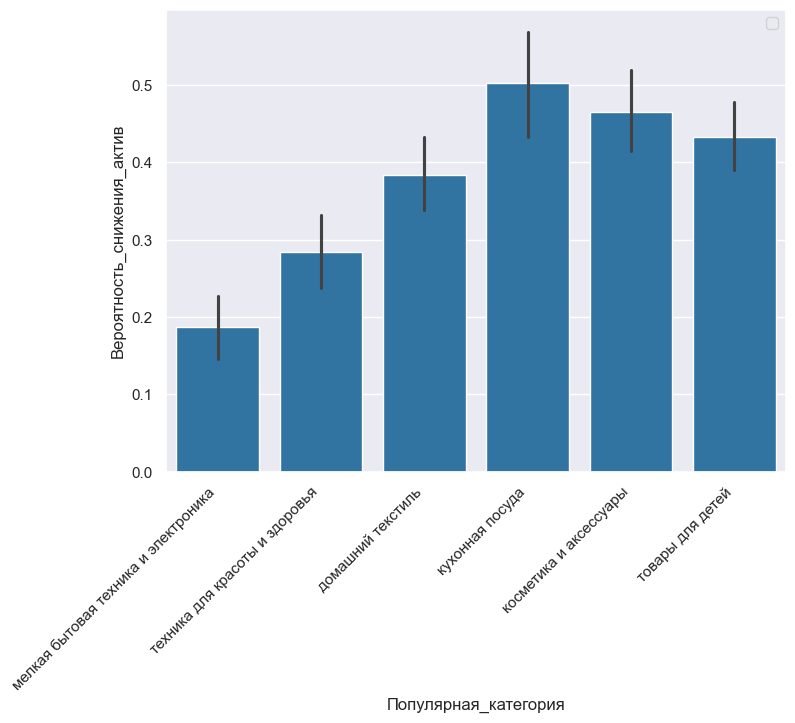

In [59]:
fig,ax = plt.subplots(figsize=(8, 6))
sns.barplot(data=new_data,
            x='Популярная_категория',
            y='Вероятность_снижения_актив',
            ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(loc="best")
plt.show()

Вероятность снижения активности у клиентов, покупающих товары `мелкая бытовая техника и электроника` и `техника для красоты и здоровья` ниже, чем у остальных категорий. Выделем таких покупателей в отдельный сегмент. 

In [60]:
segment_2 = new_data[
    (new_data['Популярная_категория'] == 'мелкая бытовая техника и электроника') 
    | (new_data['Популярная_категория'] == 'техника для красоты и здоровья')
]
# Проверим, что только две категории попали в новый датасет
display(segment_2['Популярная_категория'].value_counts())
display(segment_2)

Популярная_категория
техника для красоты и здоровья          183
мелкая бытовая техника и электроника    174
Name: count, dtype: int64

,id,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_за_прошлый_месяц,Выручка_за_предпрошлый_месяц,Выручка_за_текущий_месяц,Минут_в_прошлый_месяц,Минут_в_текущий_месяц,Вероятность_снижения_актив,Покупательская активность,Прибыль
0,215858,стандарт,да,5.5,4,510,0.15,мелкая бытовая техника и электроника,2,4,7,16,5170.5,4347.0,6014.2,20.0,6.0,0.101382,прежний уровень,4.37
1,215361,стандарт,да,5.1,4,199,0.23,техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11.0,13.0,0.914721,снизилась,4.03
2,215884,стандарт,да,4.3,5,997,0.17,мелкая бытовая техника и электроника,5,1,3,11,4113.0,4626.0,3798.4,13.0,10.0,0.076939,прежний уровень,4.37
5,216606,стандарт,нет,5.1,3,904,0.26,мелкая бытовая техника и электроника,4,1,2,12,4279.0,4534.0,4630.0,14.0,20.0,0.030510,прежний уровень,3.09
8,216186,стандарт,да,4.3,4,831,0.21,мелкая бытовая техника и электроника,5,2,3,7,3872.0,4697.0,3287.0,11.0,17.0,0.068394,прежний уровень,6.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,216233,премиум,да,3.9,4,1048,0.21,техника для красоты и здоровья,3,0,6,14,4325.0,4553.0,4257.4,15.0,17.0,0.058232,прежний уровень,4.62
1270,215365,стандарт,да,3.9,4,167,0.95,техника для красоты и здоровья,6,4,2,5,4577.0,4190.0,4799.3,6.0,10.0,0.935119,снизилась,3.65
1284,216115,стандарт,нет,4.4,4,808,0.17,мелкая бытовая техника и электроника,4,2,0,3,4802.5,4543.0,5157.4,11.0,9.0,0.566821,прежний уровень,4.06
1285,216412,стандарт,да,5.5,3,847,0.11,мелкая бытовая техника и электроника,5,1,5,4,5227.0,5233.0,5351.8,14.0,16.0,0.019913,прежний уровень,4.14


**Группа клиентов, которые покупают товары из категории «Товары для детей».**

In [61]:
segment_3 = new_data[new_data['Популярная_категория'] == 'товары для детей']
# Проверим, что только нужная категория попала в новый датасет
display(segment_3['Популярная_категория'].value_counts())
display(segment_3)

Популярная_категория
товары для детей    329
Name: count, dtype: int64

,id,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_за_прошлый_месяц,Выручка_за_предпрошлый_месяц,Выручка_за_текущий_месяц,Минут_в_прошлый_месяц,Минут_в_текущий_месяц,Вероятность_снижения_актив,Покупательская активность,Прибыль
12,215655,стандарт,да,3.9,4,819,0.94,товары для детей,1,9,4,2,4414.0,4847.0,4909.3,13.0,10.0,0.983133,снизилась,4.01
15,215725,стандарт,да,2.4,5,846,0.40,товары для детей,2,4,4,5,4995.0,4908.0,5385.0,10.0,14.0,0.973537,снизилась,5.06
17,215447,стандарт,да,2.4,5,511,0.94,товары для детей,3,2,3,3,3311.0,4677.0,3567.1,6.0,9.0,0.956254,снизилась,4.01
28,216178,стандарт,нет,3.3,4,353,0.18,товары для детей,2,2,6,15,5562.0,5010.0,5213.6,19.0,14.0,0.125027,прежний уровень,3.98
32,215829,стандарт,да,4.9,4,600,0.13,товары для детей,4,4,5,7,5636.5,4633.0,6636.2,14.0,19.0,0.095906,снизилась,4.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1288,215803,стандарт,да,3.8,4,670,0.28,товары для детей,4,4,7,9,5601.5,5273.0,6016.2,9.0,22.0,0.213600,снизилась,4.85
1290,215669,стандарт,да,4.1,3,551,0.94,товары для детей,2,3,3,5,5213.0,4934.0,5123.3,8.0,11.0,0.965695,снизилась,4.08
1291,216607,стандарт,да,3.3,4,575,0.23,товары для детей,2,4,5,8,4991.0,4463.0,5578.6,11.0,12.0,0.792261,прежний уровень,4.91
1292,215568,премиум,да,4.0,5,1073,0.40,товары для детей,4,2,3,3,2909.0,4740.0,3933.4,10.0,10.0,0.932192,снизилась,5.49


**Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.**


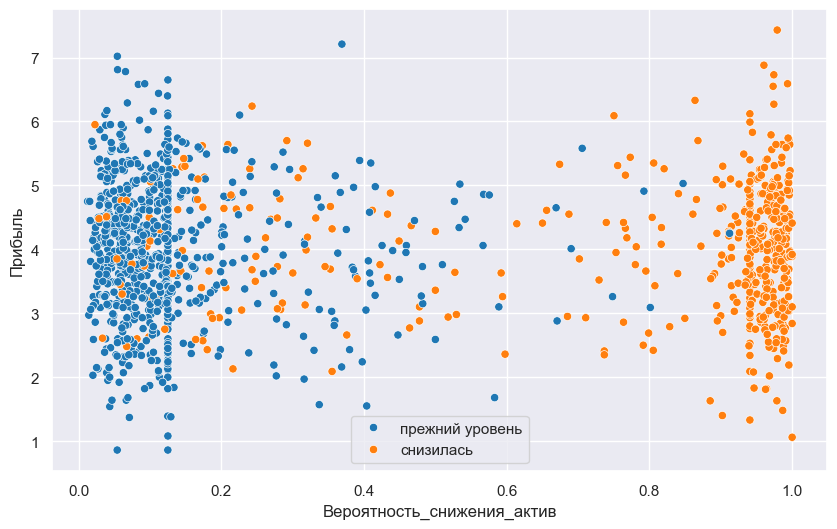

In [62]:
fig,ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=new_data,
            x='Вероятность_снижения_актив',
            y='Прибыль',
            hue='Покупательская активность', 
            ax=ax)

ax.legend(loc="best")
plt.show()

Выделим в отдельный сегмент покупателей, у которых прибыль выше 4 и вероятность снижения покупательской активности больше 0,6. 

In [63]:
segment_4 = new_data[(new_data['Вероятность_снижения_актив'] > 0.6)
                     & (new_data['Прибыль'] >= 4)]

segment_4

,id,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_за_прошлый_месяц,Выручка_за_предпрошлый_месяц,Выручка_за_текущий_месяц,Минут_в_прошлый_месяц,Минут_в_текущий_месяц,Вероятность_снижения_актив,Покупательская активность,Прибыль
1,215361,стандарт,да,5.1,4,199,0.23,техника для красоты и здоровья,4,5,2,3,6400.0,4597.0,3789.7,11.0,13.0,0.914721,снизилась,4.03
4,215714,стандарт,да,3.8,5,694,0.40,кухонная посуда,3,7,4,6,5854.0,4864.0,7063.0,13.0,9.0,0.963780,снизилась,4.85
6,215673,стандарт,нет,2.4,5,340,0.40,домашний текстиль,1,5,1,3,4604.5,4105.0,4458.9,8.0,11.0,0.991726,снизилась,4.55
12,215655,стандарт,да,3.9,4,819,0.94,товары для детей,1,9,4,2,4414.0,4847.0,4909.3,13.0,10.0,0.983133,снизилась,4.01
15,215725,стандарт,да,2.4,5,846,0.40,товары для детей,2,4,4,5,4995.0,4908.0,5385.0,10.0,14.0,0.973537,снизилась,5.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,215384,стандарт,да,4.0,4,1020,0.34,косметика и аксессуары,2,3,8,3,3584.0,4226.0,4010.4,11.0,12.0,0.865834,снизилась,4.78
1290,215669,стандарт,да,4.1,3,551,0.94,товары для детей,2,3,3,5,5213.0,4934.0,5123.3,8.0,11.0,0.965695,снизилась,4.08
1291,216607,стандарт,да,3.3,4,575,0.23,товары для детей,2,4,5,8,4991.0,4463.0,5578.6,11.0,12.0,0.792261,прежний уровень,4.91
1292,215568,премиум,да,4.0,5,1073,0.40,товары для детей,4,2,3,3,2909.0,4740.0,3933.4,10.0,10.0,0.932192,снизилась,5.49


**Рассмотрим первый сегмент. Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.**

,Популярная_категория,count
0,товары для детей,43
1,косметика и аксессуары,26
2,домашний текстиль,23
3,кухонная посуда,18
4,техника для красоты и здоровья,10
5,мелкая бытовая техника и электроника,4


C:\Users\abina\AppData\Local\Temp\ipykernel_20196\595783515.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha="right")


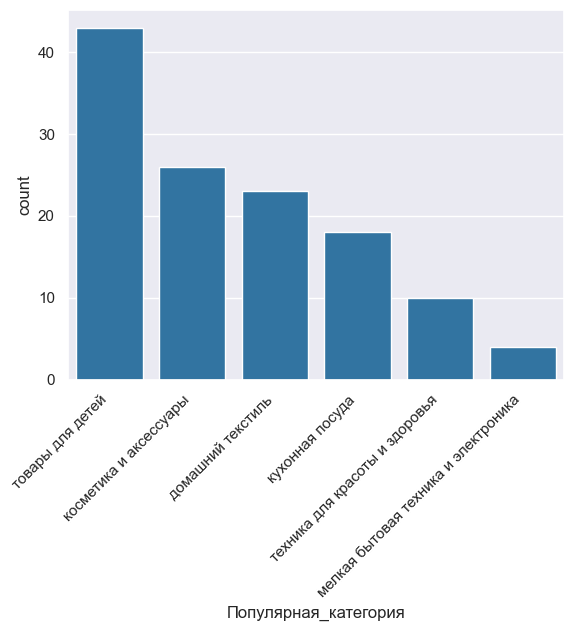

In [93]:
cat_seg_agg = segment_1['Популярная_категория'].value_counts().reset_index()
display(cat_seg_agg)
fig = sns.barplot(
    data=cat_seg_agg,
    x='Популярная_категория',
    y='count'
)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha="right")
plt.show()

,Разрешить сообщать,count
0,да,92
1,нет,32


C:\Users\abina\AppData\Local\Temp\ipykernel_20196\3318072743.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha="right")


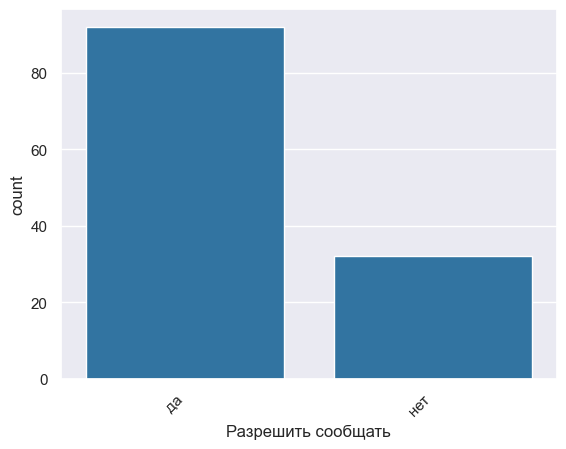

In [96]:
notif_seg_agg = segment_1['Разрешить сообщать'].value_counts().reset_index()
display(notif_seg_agg)
fig = sns.barplot(
    data=notif_seg_agg,
    x='Разрешить сообщать',
    y='count'
)

fig.set_xticklabels(fig.get_xticklabels(), rotation=45, ha="right")
plt.show()

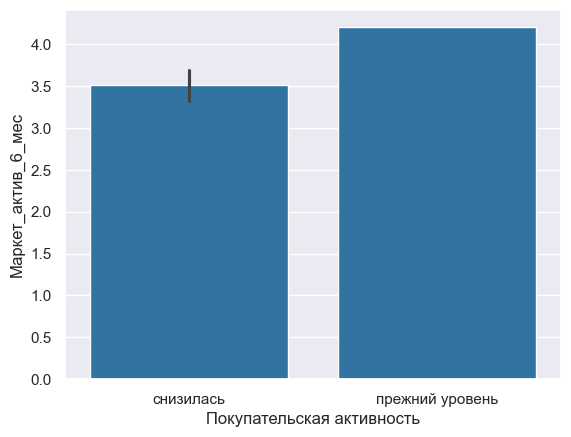

In [98]:
fig = sns.barplot(
    data=segment_1,
    x='Покупательская активность',
    y='Маркет_актив_6_мес'
)

### Вывод
Посмотрели, какие товары из интернет-магазина чаще всего покупают клиенты из первого сегмента. Лидирует категория `Товары для детей` среди остальных. Чтобы повысить покупательскую активность, можно предлагать клиенту товары из этой же категории, но уже не по акции. Возможно, эти товары заинтересуют покупателей.  Большая часть клиентов из этого сегмента (92 покупателя) дали разрешение на получение предложений о товаре, поэтому можно расслыть рекламу на товары из этой же категории. Также нужно повышать лояльность клиентов: предлагать скидки на определенные товары, бесплатную доставку или эксклюзивные предложения для постоянных клиентов. 

На последнем графике видно, что покупатели с прежним уровнем получают больше маркетинговых коммуникаций от компании, чем покупатели со сниженным уровнем, поэтому стоит больше присылать рассылок и показывать рекламу клиенту. 

## Общий вывод

**Предобработка данных:**

- Нет пропущенных значений и дубликатов;
- Исправили опечатки в категориальных признаках;
- Исправили типы данных на правильный;
- Привели категориальные признаки к нижнему регистру;
- Кириллические названия столбов оставили для удобства.

**Исследовательский анализ данных:**

- Клиенты со сниженным уровнем покупательской активности получает меньше маркетинговых коммуникаций, чем клиенты с прежним уровнем;
- Клиенты со сниженным уровнем покупают делают больше акционных покупок, товары по акции встречаются реже, чем регулярные;
- Клиенты со сниженным уровнем покупательской активности имеют больше неоплаченных товаров в корзине, зарегистрированы на сайте дольше, просматривают больше категорий и страниц, чем покупатели с прежним уровнем;
- У клиентов, не давших согласие на предложениях о товаре, уровень покупательской активности снизился;

**Корреляционный анализ данных:**
- Есть заметная корреляционная связь между целевым признаком и выручкой за прошлые периоды и страниц за визит;
- Мультиколлинеарности не наблюдается.

**Пайплайны:**
- Подготовили данные: закодировали категориальные признаки и масштабировали количественные;
- Построили пайплайны для четырех моделей: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC();
- Использовали три кодировщика StandardScaler(), MinMaxScaler(), RobustScaler();
- С помощью OptunaSearchCV() подобрали параметры и для оценивания моделей взяли метрику ROC-AUC;
- Лучшей моделью стала SVC()

**Анализ важности признаков:**
- Значимые признаки: Акционные покупки, Страниц за визит, Минут в прошлый месяц, Минут в текущий месяц
- Среднезначимые признаки: Неоплаченные продукты штук квартал, Средний просмотр категорий за визит
- Малозначимые признаки: 'Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Ошибка_сервиса', 'Длительность', 'Выручка_за_предпрошлый_месяц', 'Выручка_за_текущий_месяц'

**Сегментация покупателей:**
- Разделили клиентов на четыре сегмента;
- Для первого сегмента предложили идеи для повышения покупательской активности.